In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import LSTM
from keras.models import Sequential, load_model
from keras.callbacks import Callback

import tensorflow as tf
import keras.callbacks
import math

pd.set_option('display.float_format', lambda x : '%.10f' % x)

#read data
data = pd.read_excel('DataSet.xlsx', header=2)
data

2022-11-08 18:34:40.906723: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


,Unnamed: 0,Unnamed: 1,East X (m),North Y (m),Vx,Vy,X predicted,Y Predicted,Xest,Yest,...,Horizontal (Vpc),Longitudinal (Vpc),Horizontal (Vpc).1,Longitudinal (Vpc).1,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37
0,0.0000000000,53000.5000000000,505749.6277903410,6958338.3492955398,0.7715333344,1.5260525266,505749.7954884353,6958338.2939531002,505749.6278000000,6958338.3492999999,...,-4.7626757380,-7.4206189183,-4.7627000000,-7.4206000000,0.9827231161,0.0000110696,98.2723116094,0.0011069569,9.7081000000,1
1,0.1000000000,53000.6000000000,505749.5290683970,6958338.4601089898,1.0662390207,1.4377880062,505749.7049436744,6958338.5019007921,505749.5438000000,6958338.4634999996,...,-4.4608189052,-7.4073536367,-4.4799000000,-7.4087000000,0.8716519999,0.0718916891,87.1651999898,7.1891689089,12.5915000000,0
2,0.2000000000,53000.7000000000,505749.4303464500,6958338.5709224502,1.1725955985,1.1890834968,505749.6356922991,6958338.6038877908,505749.4486000000,6958338.5738000004,...,-4.2684563721,-7.6035585096,-4.2797000000,-7.5875000000,0.9402441567,0.0843063783,94.0244156732,8.4306378261,7.9493000000,1
3,0.3000000000,53000.8000000000,505749.2328505980,6958338.6817822298,1.0114535814,1.1076830109,505749.5476060099,6958338.6898307996,505749.2604000000,6958338.6827999996,...,-4.4657468064,-7.4732654164,-4.4449000000,-7.4830000000,0.7229714358,0.0674447458,72.2971435759,6.7444745792,31.5875000000,0
4,0.4000000000,53000.9000000000,505749.1341286440,6958338.7925956901,1.0162806849,1.3125446924,505749.3339959561,6958338.7925505312,505749.1532000000,6958338.7928999998,...,-4.2625866072,-7.1452599940,-4.2714000000,-7.1731000000,0.9437543883,0.0838434623,94.3754388335,8.3843462267,4.3317000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3849,384.9000000000,53639.1000000000,505766.2117488760,6958316.9634452099,0.0545783919,0.2439696685,505766.2223449721,6958317.0265619494,505766.2129000000,6958316.9691000003,...,-6.7621671584,-11.5820389609,-6.7523000000,-11.5555000000,1.3684459190,0.1241359794,136.8445918981,12.4135979403,0.0000000000,1
3850,385.0000000000,53639.2000000000,505766.2117488760,6958316.9634452099,0.0000000000,0.2100000000,505766.2172067152,6958316.9878421770,505766.2123000000,6958316.9661999997,...,-6.8335331487,-11.5832067185,-6.8171000000,-11.5813000000,1.3683931308,0.1243766972,136.8393130773,12.4376697151,0.0000000000,1
3851,385.1000000000,53639.3000000000,505766.2118009860,6958317.0742123397,0.0002356194,0.2699998972,505766.2117488760,6958316.9844452096,505766.2119000000,6958317.0669999998,...,-6.8331086585,-11.4191833925,-6.8221000000,-11.4325000000,1.3751621742,0.1247105032,137.5162174232,12.4710503166,29.5729000000,0
3852,385.2000000000,53639.4000000000,505766.1130272540,6958317.0742588099,0.0000000000,0.2500000000,505766.2118245480,6958317.1012123292,505766.1213000000,6958317.0758999996,...,-6.7451271217,-11.5133694200,-6.7426000000,-11.5063000000,1.2758776484,0.1165154637,127.5877648372,11.6515463746,58.0276000000,0


In [2]:
data = data.iloc[:, 12].values

In [3]:
#split data (3200 for training)
data_train = data[:3200]
data_test = data[3200:]

In [8]:
def create_dataset(data, n_predictions, n_next):
    '''
    Crteate the datasets include training dataset and label dataset for training
    
    paras:
        @data: original data
        @n_predictions: How much data to use to predict at once
        @n_next: The location of the data going to predict
            e.g. the time interval is 0.1s, 
                if want to predict the location with time interval 1s,
                n_next need to be set 10
    
    return:
        train_X: An array with 2 dimensions
            e.g. [[1,2,3..], [1,2,3...]]
        train_Y: An array with 2 dimensions
            e.g. [[1],[2],[3]]
    '''
    train_X, train_Y = [], []
    
    for i in range(data.shape[0]- n_predictions-n_next) :
        tempx = data[i: (i+n_predictions)]
        train_X.append (tempx)
        tempy = data[i+n_predictions+n_next]
        y=[]
        y.append(tempy)
        train_Y.append (y)
        
    train_X = np.array(train_X, dtype='float64')
    train_Y = np.array(train_Y, dtype='float64')
    
    return train_X, train_Y




In [20]:
def Normalize(data):
    '''
    Normalize the data into 0 and 1
    
    paras:
        @data: original data
    
    return:
        data: normalize data, type as the original data
        normalize: An array with 1 dimensions
            e.g. [high, low] 
    '''

    normalize = np.arange (2, dtype='float64')
    
    low, high = np.percentile(data, [0, 100])
    normalize[0] = low
    normalize[1] = high
    
    delta = high - low
    
    if delta != 0:
        data = (data - low)/delta
        
        
    return data, normalize

In [10]:
def trainModel(train_X, train_Y) :
    '''
    Build LSTM model with one LSTM layer
    
    paras:
        @train_X: training data
        @train_X: label data

    return:
        model: a keras LSTM model
        his: training history
    '''

    model = Sequential()
    model. add(LSTM(
        120,
        activation='tanh',
        input_shape=(100, 1),
        return_sequences=False))
    model.add (Dropout(0.2) )
    
    model.add (Dense(
        train_Y.shape[1]))
    model.add (Activation("tanh"))
    
    model.compile(loss='mse', optimizer='adam', metrics=['mse'])
    his = model.fit(train_X, train_Y, epochs=80, batch_size=64, verbose=1)
    model.summary()
    
    
    return model, his



In [11]:
#take 100 records to predict
train_num = 100

#time interval 1s
per_num = 10

data, nor = Normalize(data_train)
train_X, train_Y = create_dataset(data, train_num, per_num)

print(nor)

print('train_X:', train_X.shape)
print('train_Y:', train_Y.shape)


[505669.6903535  505873.99526411]
train_X: (3080, 100)
train_Y: (3080, 1)


In [46]:
train_X

array([[0.10386455, 0.10144923, 0.09855044, ..., 0.07346568, 0.07491558,
        0.07539855],
       [0.10144923, 0.09855044, 0.09613511, ..., 0.07491558, 0.07539855,
        0.07636498],
       [0.09855044, 0.09613511, 0.09323606, ..., 0.07539855, 0.07636498,
        0.07684795],
       ...,
       [0.01690561, 0.01690561, 0.01690561, ..., 0.02803769, 0.02948835,
        0.03045554],
       [0.01690561, 0.01690561, 0.01690561, ..., 0.02948835, 0.03045554,
        0.0319062 ],
       [0.01690561, 0.01690561, 0.01690561, ..., 0.03045554, 0.0319062 ,
        0.03287314]])

In [47]:
train_Y

array([[0.08843636],
       [0.08891857],
       [0.09036796],
       ...,
       [0.05559267],
       [0.05607563],
       [0.05704207]])

In [15]:
#training
model, his = trainModel(train_X, train_Y, )
loss, acc = model.evaluate(train_X, train_Y, verbose=2)
print(f'Loss:{loss}, Accuracy:{acc*100}')

2022-11-08 18:35:45.007593: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/80
49/49 [==============================] - 5s 67ms/step - loss: 0.0339 - mse: 0.0339
Epoch 2/80
49/49 [==============================] - 3s 67ms/step - loss: 0.0050 - mse: 0.0050
Epoch 3/80
49/49 [==============================] - 3s 68ms/step - loss: 0.0041 - mse: 0.0041
Epoch 4/80
49/49 [==============================] - 4s 73ms/step - loss: 0.0033 - mse: 0.0033
Epoch 5/80
49/49 [==============================] - 3s 68ms/step - loss: 0.0019 - mse: 0.0019
Epoch 6/80
49/49 [==============================] - 3s 69ms/step - loss: 9.6166e-04 - mse: 9.6166e-04
Epoch 7/80
49/49 [==============================] - 3s 71ms/step - loss: 9.3126e-04 - mse: 9.3126e-04
Epoch 8/80
49/49 [==============================] - 3s 69ms/step - loss: 8.9353e-04 - mse: 8.9353e-04
Epoch 9/80
49/49 [==============================] - 4s 76ms/step - loss: 0.0011 - mse: 0.0011
Epoch 10/80
49/49 [==============================] - 3s 69ms/step - loss: 7.6118e-04 - mse: 7.6118e-04
Epoch 11/80
49/49 [========

_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 120)               58560     
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense (Dense)               (None, 1)                 121       
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 58,681
Trainable params: 58,681
Non-trainable params: 0
_________________________________________________________________
97/97 - 2s - loss: 2.8919e-04 - mse: 2.8919e-04 - 2s/epoch - 23ms/step
Loss:0.00028918820316903293, Accuracy:0.028918820316903293


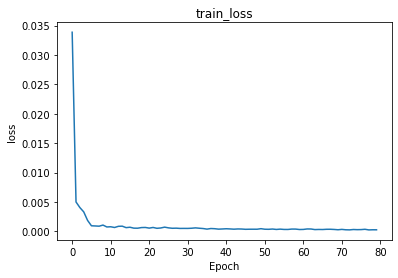

In [16]:
#show the training history
import matplotlib.pyplot as plt

plt.title('train_loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.plot(his.history['loss'])



In [34]:
def UnNormalize(data, normalize):
    '''
    UnNormalize the predicted data to evaluate the result
    
    paras:
        @data: normalize data
        @normalize: normalize array with 1 dimensions
            e.g. [high, low]

    return:
        data: UnNormalize data, type as the input data
    
    '''
    data = np.array(data, dtype='float64')
    
    low = normalize[0]
    high = normalize[1]
    delta = high - low
    if delta != 0:
        for i in range(0, data.shape[0]) :
            data[i] = data[i]*delta + low
    return data

In [38]:
#prepare testing data 
data, nor = Normalize(data_test)
test_X, test_Y = create_dataset(data, train_num, per_num)


In [39]:
#predict testing data
predicted_y = model.predict(test_X)

17/17 [==============================] - 0s 24ms/step


In [40]:
#UnNormalize testing data
predicted_y = UnNormalize(predicted_y, nor)
test_Y = UnNormalize(test_Y, nor)

In [41]:
#transfer data into dataframe to show results
pred = pd.DataFrame(predicted_y).rename(columns={0:'predict_x'})
test = pd.DataFrame(test_Y).rename(columns={0:'test_x'})

final = pd.concat([pred, test], axis=1)
final



,predict_x,test_x
0,505722.0705328478,505720.8197250550
1,505722.2916299711,505721.1157900150
2,505722.4938968678,505721.6092487950
3,505722.6877569537,505721.9053653920
4,505722.9375899810,505722.1027075000
...,...,...
529,505796.1646683156,505806.3842166330
530,505795.6126277435,505805.6933810490
531,505795.0995348191,505805.0025453310
532,505794.6162132752,505804.3116570130


In [42]:
#show the predicted error(distance)
final['distance'] =abs(final['predict_x']-final['test_x'])
final                           

,predict_x,test_x,distance
0,505722.0705328478,505720.8197250550,1.2508077928
1,505722.2916299711,505721.1157900150,1.1758399560
2,505722.4938968678,505721.6092487950,0.8846480728
3,505722.6877569537,505721.9053653920,0.7823915617
4,505722.9375899810,505722.1027075000,0.8348824810
...,...,...,...
529,505796.1646683156,505806.3842166330,10.2195483174
530,505795.6126277435,505805.6933810490,10.0807533055
531,505795.0995348191,505805.0025453310,9.9030105119
532,505794.6162132752,505804.3116570130,9.6954437378


In [43]:
#show the MAE
final['distance'].mean()

2.7534515420970123

In [43]:
pd.set_option('display.max_rows', None)

In [44]:
final

,predict_x,test_x,distance
0,505720.2046355996,505720.8197250550,0.6150894554
1,505720.4715339667,505721.1157900150,0.6442560483
2,505720.7308807923,505721.6092487950,0.8783680028
3,505720.9892493499,505721.9053653920,0.9161160421
4,505721.3326871675,505722.1027075000,0.7700203325
5,505721.7135680453,505722.3988240590,0.6852560137
6,505722.1294005468,505722.5962178490,0.4668173022
7,505722.5711514264,505722.7935599120,0.2224084856
8,505723.0107884464,505722.9909536770,0.0198347694
9,505723.4473733851,505723.1883991540,0.2589742311
